In [1]:
import numpy as np
import pandas as pd
import os
from shutil import copyfile
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.metrics.pairwise import euclidean_distances
import shutil

import neuro_morpho_toolbox as nmt
%matplotlib inline



/Users/pengxie/Documents/Research/python/neuro_morhpo_toolbox/neuro_morpho_toolbox/
Loading CCF Atlas data...
Loading time: 0.57
Loading CCF brain structure data...
Loading time: 0.00
Loading flat_map ...
Loading time: 2.62


In [2]:
[metadata] = pickle.load(open('./metadata.pickle', 'rb'))
metadata.to_excel('./metadata.xlsx')

In [5]:
len(metadata['brain'].unique())

32

In [4]:
def get_dict_target(target_regions):
    res = {}
    for cur_region in target_regions:        
        child_ids = nmt.bs.get_all_child_id(cur_region)
        for i in child_ids:
            res[nmt.bs.id_to_name(i)] = cur_region
    return res

ctx_dict = get_dict_target(['CTX'])
layers = ('1', '2/3', '4', '5', '6a', '6b')
def get_layer(soma):
    if soma[['x', 'y', 'z']].isna().any().any():
        return 'unknown'
    soma_int = soma[['x', 'y', 'z']].copy()
    soma_int['x'] = soma_int['x']/nmt.annotation.space['x']
    soma_int['y'] = soma_int['y']/nmt.annotation.space['y']
    soma_int['z'] = soma_int['z']/nmt.annotation.space['z']
    soma_int = soma_int.round(0).astype(int)
    if ((soma_int.x.iloc[0] >= 0) & (soma_int.x.iloc[0] < nmt.annotation.size['x']) &
        (soma_int.y.iloc[0] >= 0) & (soma_int.y.iloc[0] < nmt.annotation.size['y']) &
        (soma_int.z.iloc[0] >= 0) & (soma_int.z.iloc[0] < nmt.annotation.size['z'])
        ):
        soma_region_id = nmt.annotation.array[soma_int.x.iloc[0],
                                          soma_int.y.iloc[0],
                                          soma_int.z.iloc[0]
        ]
    if soma_region_id == 0:
        return 'unknown'
    res = nmt.bs.id_to_name(soma_region_id)
    if not res in ctx_dict.keys():  # Only consider cortical regions regions
        return 'unknown'
    for i in layers:
        if res.endswith(i):
            return i
    return 'unknown'



## 1. Registration-based cell typing

In [5]:
selected_region_names = [nmt.bs.id_to_name(i) for i in nmt.bs.selected_regions]
selected_dict = get_dict_target(selected_region_names)
valid_names = list(selected_dict.keys())

In [6]:
rlist = []
llist = []
swc_dir = '/Users/pengxie/Documents/Research/Thalamus_fullMorpho/Data/swc/combined/1_flip_s25/'
swc_list = sorted([i for i in os.listdir(swc_dir) if i.endswith('.swc')])
name_list = [i.split('.')[0].replace('r10_', '') for i in swc_list]

ct = 0
for cswc, cname in zip(swc_list, name_list):
    cn = None
    cn = nmt.neuron(swc_dir+cswc, scale=25)
    if cn is None:
        print(cn)
        rlist.append('unknown')
        llist.append('unknown')
    else:
        cregion = cn.soma.region[0]
        rlist.append(cregion)
        llist.append(get_layer(cn.soma))
    ct += 1
#     if ct>10:
#         break
        
res = pd.DataFrame({'registration_region':rlist, 
                    'registration_layer':llist,
                   }, index=name_list[:len(rlist)])
res.head()

,registration_region,registration_layer
17109_1701_x8048_y22277,AId,5
17109_1801_x6698_y12550,AId,6a
17109_1901_x9602_y10508,AId,2/3
17109_2201_x8046_y23301,MOs,6a
17109_2301_x8535_y23051,AId,6a


## 2. Manual cell types

### 2.1 SEU manual celltypes

In [7]:
df_seu = pd.read_excel("/Users/pengxie/Documents/Research/Thalamus_fullMorpho/Data/Hanchuan/from/soma_region_seu_LJL_px_06172020.xlsx",
                          index_col=[0])

valid_names_lijuan = valid_names+['OLF', 'HPF', 'OB']
# Standardize names
tp = df_seu.loc[~df_seu.manual.isin(valid_names_lijuan), 'manual']
print(tp.value_counts().head(10))

standard_dict = {
    'CPU':'CP',
    'CPu':'CP',
    'Cpu':'CP',
    'Mop':'MOp',
    'Gpi':'GPi',
    'Claustrum':'CLA',
    'Accumbens':'ACB',
    'Olfactory tubercle':'OT',
    'Hippocampus':'HPF',
    'Piriform cortex':'PIR',
    'Amygdala':'OLF'
}

for i in df_seu.index.tolist():
    ctype = df_seu.loc[i, 'manual']
    if ctype in list(standard_dict.keys()):
        ctype = standard_dict[ctype]
    elif ctype in valid_names:
        ctype = selected_dict[ctype]
    else:
        ctype = np.NAN
    df_seu.loc[i, 'manual'] = ctype
df_seu = df_seu[~df_seu.manual.isna()]
print(df_seu.manual.shape[0])
df_seu.manual.isin(valid_names_lijuan).all()

SSp    1
Mop    1
Gpi    1
Name: manual, dtype: int64
1055


True

### 2.2 Allen manual celltypes

In [8]:
# def is_number(s):
#     try:
#         float(s) # for int, long and float
#     except ValueError:
#         try:
#             complex(s) # for complex
#         except ValueError:
#             return False
#     return True

# ## Read dataframe
# df_allen = pd.read_excel('/Users/pengxie/Documents/Research/Thalamus_fullMorpho/Data/Yun/from/Allen_soma_region_mannualRegistration.xlsx',
#                           skip_rows=[i for i in range(25)],
#                           header=[25], 
#                           index_col=[1],
#                           usecols=[2,3,5,6,7,8])
# df_allen.head()

# # Keep manually annotated neurons
# df_allen = df_allen[~df_allen['Reconstructor Assigned Soma Location'].isna()]
# df_allen.shape

# # Rename to match with SWC files
# new_ind = []
# for i in df_allen.index.tolist():
#     cbrain = df_allen.loc[i, 'ALLEN-HUST Brain ID'].replace('-', '_').split('_')[-1]
#     new_ind.append(cbrain+'-'+i)
# df_allen.index = new_ind

# nlist = []
# for cf in new_ind:
#     tp = cf.replace('-', '_').upper().split('.')[0].split('_')
#     cb = tp[0]
#     cz = tp[1]
#     cx = 'a'
#     cy = 'a'
#     for i in tp:
#         if i.startswith('X'):
#             cx = i[1:]
#         elif i.startswith('Y'):
#             cy = i[1:]
#     if ((not is_number(cx)) | (not is_number(cy)) | (not is_number(cz))):
#         print(cf)
#         nlist.append(np.nan)
#         continue
#     nlist.append("%s_%d_x%d_y%d" % (cb, int(cz), int(cx), int(cy)))
    
# df_allen['Standard_ID'] = nlist
# df_allen = df_allen[~df_allen['Standard_ID'].isna()]
# df_allen.columns = ['Brain_ID', 'Manual_Region', 'Whether_border', 'Celltype', 'Layer', 'Standard_ID']
# df_allen.index = df_allen.Standard_ID.tolist()


# selected_region_names = [nmt.bs.id_to_name(i) for i in nmt.bs.selected_regions]
# df_allen = df_allen[df_allen['Manual_Region'].isin(selected_region_names)]

# print(df_allen.shape)
# df_allen.head()


In [9]:
df_allen = pd.read_excel('/Users/pengxie/Documents/Research/Thalamus_fullMorpho/Data/Yun/to/soma_region_px.xlsx', index_col=[0])
selected_region_names = [nmt.bs.id_to_name(i) for i in nmt.bs.selected_regions]
df_allen = df_allen[df_allen['manual_region'].isin(selected_region_names)]


In [10]:
df_allen.head()

,registration_region,registration_layer,manual_region,manual_layer,manual_valid,Yun_celltype,matched,region,layer,rough_region
17300_3426_x20339_y44872,SSs,5,SSs,5,True,SPC_bi,1.0,SSs,5,CTX
17300_5896_x24862_y27320,RSPv,5,RSPv,5,True,SPC_bi,1.0,RSPv,5,CTX
17300_5969_x27278_y20820,VISpm,2/3,VISp,5,True,SPC_bi,0.0,VISp,5,CTX
17543_2434_x11441_y5587,SSp-m,4,SSp-m,4,True,UPC_bi,1.0,SSp-m,4,CTX
17543_3308_x10077_y3766,SSs,5,SSp-m,4,True,SSC_ips,0.0,SSp-m,4,CTX


## Allen Thalamic

In [11]:
'''
A final check of the thalamic neurons by Hongkui, Peng and Quanxin
'''

'\nA final check of the thalamic neurons by Hongkui, Peng and Quanxin\n'

In [12]:
hz_df = pd.read_excel('../Data/Hongkui/TH_medial_soma_checkQW_hz_QW.xlsx', sheet_name='For_figures', index_col=[0])
hz_df.loc[hz_df['Confirmed'].isin(['posterior MD', 'anterior MD']), 'Confirmed'] = 'MD'

## Allen cortical

In [13]:
hz_df1 = pd.read_excel('../Data/Hongkui/metadata_IT_hz2.xlsx', index_col=[0])
hz_df1 = hz_df1[hz_df1['Region'].isin(['MOp', 'MOs', 'SSs'])]
hz_df1['Region'].value_counts()

MOp    20
MOs    18
SSs    15
Name: Region, dtype: int64

In [14]:
hz_df2 = pd.read_excel('../Data/Hongkui/metadata_L5_ET.xlsx', index_col=[0])
hz_df2 = hz_df2[hz_df2['CellType'].isin(['MOp', 'MOs', 'SSs'])]
hz_df2['CellType'].value_counts()

SSs    19
MOp    13
MOs     4
Name: CellType, dtype: int64

## Update region with manual assignment

In [15]:
res['region'] = res['registration_region']
res['layer'] = res['registration_layer']
res['manual_region'] = None
res['manual_layer'] = None
res['Yun_celltype'] = None

## SEU_manual
cell_index = res.index[res.index.isin(df_seu.index)]
res.loc[cell_index, 'manual_region'] = df_seu.loc[cell_index, 'manual'].tolist()

## Allen_manual
cell_index = res.index[res.index.isin(df_allen.index)]
res.loc[cell_index, 'manual_region'] = df_allen.loc[cell_index, 'manual_region'].tolist()
res.loc[cell_index, 'manual_layer'] = df_allen.loc[cell_index, 'manual_layer'].tolist()
res.loc[cell_index, 'Yun_celltype'] = df_allen.loc[cell_index, 'Yun_celltype'].tolist()
res.loc[cell_index, 'layer'] = df_allen.loc[cell_index, 'layer'].tolist()

## Allen thalamic check
res.loc[hz_df.index, 'manual_region'] = hz_df['Confirmed'].tolist()

## Allen cortical check
cell_index = res.index[res.index.isin(hz_df1.index)]
res.loc[cell_index, 'manual_region'] = hz_df1.loc[cell_index, 'Region'].tolist()
res.loc[cell_index, 'manual_layer'] = hz_df1.loc[cell_index, 'Corrected Layer'].tolist()
res.loc[cell_index, 'Yun_celltype'] = hz_df1.loc[cell_index, 'Yun_celltype'].tolist()
res.loc[cell_index, 'layer'] = hz_df1.loc[cell_index, 'Corrected Layer'].tolist()

cell_index = res.index[res.index.isin(hz_df2.index)]
res.loc[cell_index, 'manual_region'] = hz_df2.loc[cell_index, 'CellType'].tolist()
res.loc[cell_index, 'manual_layer'] = hz_df2.loc[cell_index, 'Layer'].tolist()
res.loc[cell_index, 'Yun_celltype'] = hz_df2.loc[cell_index, 'Yun_celltype'].tolist()
res.loc[cell_index, 'layer'] = hz_df2.loc[cell_index, 'Layer'].tolist()

## replace registration regions
res.loc[~res['manual_region'].isna(), 'region'] = res.loc[~res['manual_region'].isna(), 'manual_region']

res.head()

,registration_region,registration_layer,region,layer,manual_region,manual_layer,Yun_celltype
17109_1701_x8048_y22277,AId,5,AId,5,None,None,None
17109_1801_x6698_y12550,AId,6a,AId,6a,None,None,None
17109_1901_x9602_y10508,AId,2/3,AId,2/3,None,None,None
17109_2201_x8046_y23301,MOs,6a,MOs,6a,None,None,None
17109_2301_x8535_y23051,AId,6a,AId,6a,None,None,None


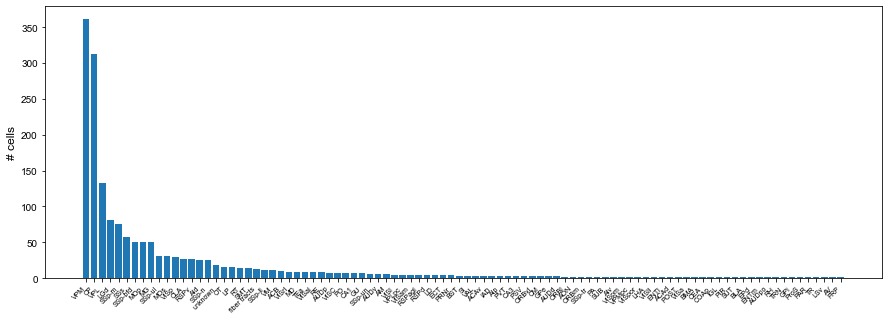

In [16]:
vs = res.region.value_counts()
ns = vs.index.tolist()
xs = np.arange(len(ns))

fig, ax = plt.subplots(1,1, figsize=(15,5))
ax.bar(xs, vs)
ax.set_xticks(xs)
_ = ax.set_xticklabels(ns, fontdict={'rotation':45, 'fontsize':7, 'ha':'right'})
_ = ax.set_ylabel('# cells', fontdict={'fontsize':12})

fig.savefig('../Figure/cell_counts.pdf', bbox_inches='tight')

## 3. Get rough region divisions

In [17]:
# Use a rougher region division
rough_dict = get_dict_target(['CNU', 'TH', 'HY', 'CTX', 'HPF', 'HB'])
tp = []
for cur_region in res.region.tolist():
    if not cur_region in list(rough_dict.keys()):
        tp.append('unknown')
    else:
        tp.append(rough_dict[cur_region])
    
res['rough_region'] = tp

res.rough_region.value_counts()

TH         735
CTX        561
CNU        351
unknown     31
HPF         19
HB           9
HY           2
Name: rough_region, dtype: int64

## 4. brain info

In [18]:
brain_df = pd.read_excel("/Users/pengxie/Documents/Research/fMOST_project/data/fMOST project summary.xlsx")["Brain ID"].tolist()
cre_list = []
brain_list = []
for i in brain_df:
#     cre_list.append(i.split(";")[0].split("-")[0].strip())
    cre_list.append(i.strip())
    brain_list.append(i.split("-")[-1].strip())
brain_df = pd.DataFrame({"Cre-line":cre_list,
                         "Brain":brain_list,
                        },index=brain_list)
brain_df
brain_df.drop_duplicates(inplace=True)

In [19]:
res['brain'] = [i.split('_')[0] for i in res.index.tolist()]
res['cre-line'] = np.nan
idx = res.index[res.brain.isin(brain_df.index)].tolist()
res.loc[idx, 'cre-line'] = brain_df.loc[res.brain.loc[idx], 'Cre-line'].tolist()

In [20]:
res = res.sort_values(['cre-line', 'brain', 'rough_region', 'region'])
res = res[['registration_region', 'manual_region', 'region', 'rough_region', 
           'registration_layer', 'manual_layer', 'layer',
           'Yun_celltype', 'brain', 'cre-line']]
pickle.dump([res], open('./metadata.pickle', 'wb'))
res.head()

,registration_region,manual_region,region,rough_region,registration_layer,manual_layer,layer,Yun_celltype,brain,cre-line
18461_3220_x7596_y9465,AIv,None,AIv,CTX,2/3,None,2/3,None,18461,Cux2-CreERT2;Ai166_374706-18461
18461_3871_x7813_y3857,MOp,MOp,MOp,CTX,2/3,2/3,2/3,TPC_bi,18461,Cux2-CreERT2;Ai166_374706-18461
18461_4178_x16825_y2713,MOp,MOp,MOp,CTX,2/3,2/3,2/3,TPC_bi,18461,Cux2-CreERT2;Ai166_374706-18461
18461_2985_x10744_y3095,MOs,MOs,MOs,CTX,1,2/3,2/3,TPC_bi,18461,Cux2-CreERT2;Ai166_374706-18461
18461_5025_x23630_y4542,SSp-bfd,SSp-bfd,SSp-bfd,CTX,1,2/3,2/3,TPC_bi,18461,Cux2-CreERT2;Ai166_374706-18461


In [21]:
res[['region', 'layer', 'rough_region', 'brain', 'cre-line']].to_csv('/Users/pengxie/Documents/Research/Thalamus_fullMorpho/Data/Hanchuan/to/soma_region.csv')

In [22]:
'''
Thalamic list sent to Hongkui
'''
tp = res[res.rough_region.isin(['TH'])].copy()
tp[['region', 'registration_region', 'brain', 'cre-line']].sort_values(['region', 'brain', 'cre-line']).to_excel('../Data/Hongkui/metadata_Thalamus.xlsx')

## 5. Celltype counts

In [20]:
ct = res.copy()
ct['cre-line'] = [str(i).split('-')[0] for i in ct['cre-line'].tolist()]

# Combine SSp types
idlist = [i for i in ct.index.tolist() if ct.loc[i, 'region'].startswith('SSp')]
ct.loc[idlist, 'region'] = 'SSp'


ct['cre-line'].value_counts()

Tnnt1     636
Vipr2     411
Pvalb     290
Cux2      170
nan        77
Gnb4       75
Fezf2      29
Plxnd1     20
Name: cre-line, dtype: int64

In [21]:
# Thalamus
ct[(ct['rough_region'].isin(['TH']))]['region'].value_counts().sort_index()

AM         6
AV         1
CM         3
IAD        3
IGL        1
LD         4
LGd       81
LP        16
MD         9
MG        50
PO         7
PVT        3
RE         8
RH         1
RT        14
SMT       14
VAL        3
VM        11
VPL      132
VPLpc      5
VPM      361
VPMpc      2
Name: region, dtype: int64

In [22]:
# CNU
ct[(ct['rough_region'].isin(['CNU']))]['region'].value_counts().sort_index()

ACB     10
BST      3
CEA      1
CP     313
GPe      3
GPi      1
LSv      1
OT      16
SI       3
Name: region, dtype: int64

In [23]:
# HPF
ct[(ct['rough_region'].isin(['HPF']))]['region'].value_counts().sort_index()

CA1     7
CA3     3
ENTl    2
ENTm    1
PAR     1
POST    2
ProS    1
SUB     2
Name: region, dtype: int64

In [24]:
# HB
ct[(ct['rough_region'].isin(['HB']))]['region'].value_counts().sort_index()

PRNr    4
PSV     3
SUT     1
TRN     1
Name: region, dtype: int64

In [25]:
ct[ct['rough_region']=='unknown']

,registration_region,manual_region,region,rough_region,registration_layer,manual_layer,layer,Yun_celltype,brain,cre-line
18047_00022,fiber tracts,None,fiber tracts,unknown,unknown,None,unknown,None,18047,Fezf2
18047_5719_x25513_y7957,fiber tracts,None,fiber tracts,unknown,unknown,None,unknown,None,18047,Fezf2
18867_4621_x24147_y14734,fiber tracts,None,fiber tracts,unknown,unknown,None,unknown,None,18867,Pvalb
18867_4677_x24410_y14710,fiber tracts,None,fiber tracts,unknown,unknown,None,unknown,None,18867,Pvalb
18867_4926_x25796_y14504,fiber tracts,None,fiber tracts,unknown,unknown,None,unknown,None,18867,Pvalb
18867_5083_x14145_y15212,fiber tracts,None,fiber tracts,unknown,unknown,None,unknown,None,18867,Pvalb
18867_4533_x14227_y15937,unknown,None,unknown,unknown,unknown,None,unknown,None,18867,Pvalb
18867_4789_x23709_y15765,unknown,None,unknown,unknown,unknown,None,unknown,None,18867,Pvalb
18867_4874_x16831_y16618,unknown,None,unknown,unknown,unknown,None,unknown,None,18867,Pvalb
18867_5082_x26232_y14941,unknown,None,unknown,unknown,unknown,None,unknown,None,18867,Pvalb


In [26]:
metadata.loc['18868_3419_x27168_y8481']

registration_region                                     MOp
manual_region                                         SSp-m
region                                                SSp-m
rough_region                                            CTX
registration_layer                                        5
manual_layer                                              5
layer                                                     5
Yun_celltype                                        TPC_sim
brain                                                 18868
cre-line               Pvalb-T2A-CreERT2;Ai166_396476-18868
Name: 18868_3419_x27168_y8481, dtype: object